# Module 1

Import relevant modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import os
from skimage import io, color, filters, morphology, measure, transform, img_as_ubyte
from scipy import ndimage as ndi
from skimage.morphology import binary_closing, disk
import math
from scipy.spatial.distance import pdist, squareform

### Exercise 1.1 

Since the butterflies are all yellow, blue, or orange, let's classify the butterflies by counting the number of pixels of each colour. To mitigate effects from the background, lets crop the image slightly to focus on the middle region of each image since the butterflies are all well centered.

In [2]:
crop_fraction = 0.4 # fine tuned parameter
image_folder = "../data" 

# Hue ranges in HSV space (hue from 0 to 1)
colour_ranges = {
    "yellow": (45 / 360, 65 / 360),
    "orange": (15 / 360, 45 / 360),
    "blue":   (200 / 360, 260 / 360),
}

In [ ]:
def classify_by_dominant_colour(image_path, crop_fraction=crop_fraction):
    """
    Classifies an image based on its dominant colour within a cropped central region.

    Parameters:
        image_path (str): The file path to the input image.
        crop_fraction (float): Fraction (0 < crop_fraction < 1) of the image to crop 
                               from the center for analysis.

    Returns:
        str: The name of the dominant colour detected (e.g., "yellow", "orange", "blue").
    """
    image = io.imread(image_path)

    h, w, _ = image.shape
    ch, cw = int(h * crop_fraction), int(w * crop_fraction)
    start_y, start_x = (h - ch) // 2, (w - cw) // 2
    cropped = image[start_y:start_y + ch, start_x:start_x + cw]

    hsv = color.rgb2hsv(cropped)
    hue = hsv[:, :, 0]
    sat = hsv[:, :, 1]
    val = hsv[:, :, 2]

    mask = (sat > 0.3) & (val > 0.2) & (val < 0.855) # fine tuned parameters to get mask 
    hue = hue[mask]
    colour_counts = {}
    
    for colour_name, (low, high) in colour_ranges.items():
        count = np.sum((hue >= low) & (hue <= high)) # use bitwise and
        colour_counts[colour_name] = count

    return max(colour_counts, key=colour_counts.get)

def group_images_by_colour(folder):
    """
    Groups images in a folder by their dominant colour.

    Parameters:
        folder (str): Path to the directory containing .jpg images.

    Returns:
        dict: A dictionary where keys are colour names ("yellow", "orange", "blue") 
              and values are lists of image filenames classified under each colour.
    """
    colour_groups = {"yellow": [], "orange": [], "blue": []}

    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg')):
            path = os.path.join(folder, filename)
            label = classify_by_dominant_colour(path)
            colour_groups[label].append(filename)

    return colour_groups


YELLOW group:
  - Image_129.jpg
  - Image_6.jpg
  - Image_177.jpg
  - Image_559.jpg


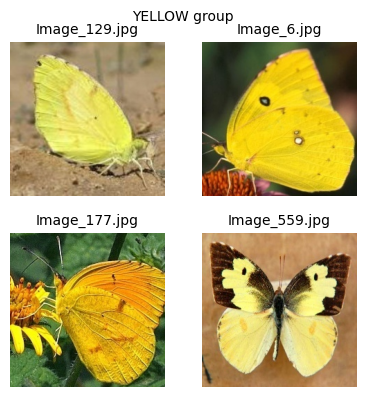


ORANGE group:
  - Image_643.jpg
  - Image_264.jpg
  - Image_1587.jpg
  - Image_1057.jpg


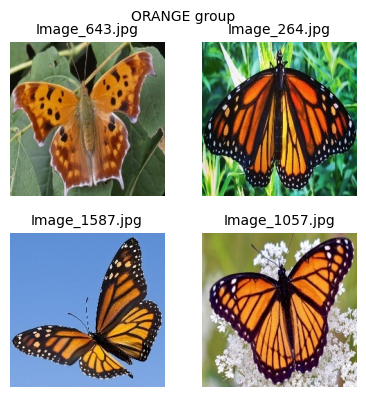


BLUE group:
  - Image_241.jpg
  - Image_260.jpg
  - Image_205.jpg
  - Image_216.jpg


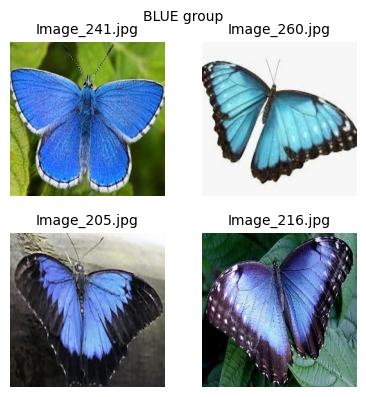

In [4]:
groups = group_images_by_colour(image_folder)

for colour, files in groups.items():
    print(f"\n{colour.upper()} group:")
    for f in files:
        print(f"  - {f}")

    fig, axs = plt.subplots(2, 2, figsize=(4, 4))
    fig.suptitle(f"{colour.upper()} group", fontsize=10)

    axs = axs.flatten() # Flatten axs array for easy iteration

    for i in range(4):
        ax = axs[i]
        ax.axis('off')  

        if i < len(files):
            img_path = os.path.join(image_folder, files[i])
            img = io.imread(img_path)
            ax.imshow(img)
            ax.set_title(files[i], fontsize=10)
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9) 
    plt.show()

### Exercise 1.2

Let's use gradient based edge detection to extract the butterfly region and set everything else as background (white)

In [ ]:
def extract_butterfly_by_gradient(image, gradient_thresh, min_size):
    """
    Segments the butterfly from the background in an image using gradient-based edge detection.

    Parameters:
        image (ndarray): Input RGB image as a NumPy array.
        gradient_thresh (float): Threshold for gradient magnitude to identify edges.
        min_size (int): Minimum area (in pixels) of objects to retain; smaller regions are removed.

    Returns:
        ndarray: A copy of the input image with the background set to white and only the largest 
                 segmented object (assumed to be the butterfly) retained.
    """

    gray = color.rgb2gray(image) # convert to grayscale because edge detection works on intensity
    gradient_mag = filters.sobel(gray) # detect edges
    edges = gradient_mag > gradient_thresh # threshold the edges
    closed_edges = binary_closing(edges, disk(5)) # fill small gaps in edges to make them continuous
    filled = ndi.binary_fill_holes(closed_edges) # fills the region inside the enclosed areas
    cleaned = morphology.remove_small_objects(filled, min_size=min_size)

    labeled = measure.label(cleaned) # labels each connected object and measure the region properties below
    regions = measure.regionprops(labeled)

    largest_region = max(regions, key=lambda r: r.area) # find the region with the largest area, assumed to be the butterfly
    final_mask = labeled == largest_region.label

    result = image.copy()
    result[~final_mask] = [255, 255, 255] # use butterfly mask to kepp the butterfly and sets the background to white
    return result

def batch_segment_and_save(folder, output_folder, gradient_thresh, min_size):
    """
    Applies butterfly segmentation to all .jpg images in a folder and saves the results.

    Parameters:
        folder (str): Path to the directory containing input .jpg images.
        output_folder (str): Path where segmented images will be saved.
        gradient_thresh (float): Threshold for edge detection during segmentation.
        min_size (int): Minimum size of detected object regions to retain.

    Returns:
        None
    """
    os.makedirs(output_folder, exist_ok=True)
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg'))]

    cols = 4
    rows = int(np.ceil(len(files) / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()

    for i, fname in enumerate(sorted(files)):
        path = os.path.join(folder, fname)
        image = io.imread(path)
        result = extract_butterfly_by_gradient(image, gradient_thresh, min_size)

        # Save processed image
        save_path = os.path.join(output_folder, fname)
        io.imsave(save_path, result.astype(np.uint8))

        axs[i].imshow(result)
        axs[i].set_title(fname, fontsize=20)
        axs[i].axis('off')


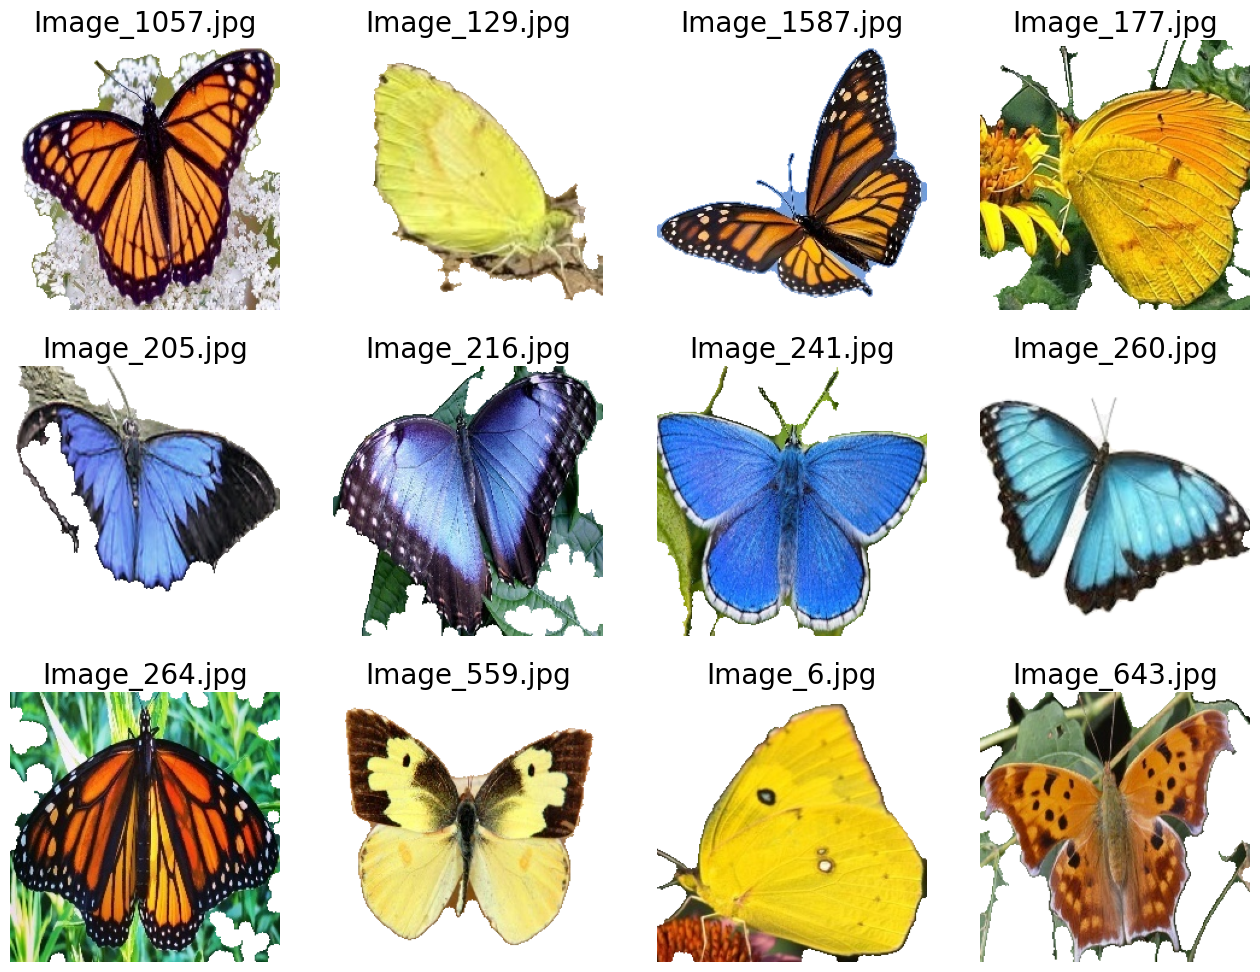

In [6]:
folder = "../data"  # Input folder
output_folder = "../data/background_removed"  # Where to save the background removed images

batch_segment_and_save(
    folder=folder,
    output_folder=output_folder,
    gradient_thresh=0.1,
    min_size=10,
)

### Exercise 1.3

Now need to put the background removed butterflies by group into a 'collage' of butterflies. Want to try and make the arrangement as square as possible, for example 4 images should be in 2x2 grid, not a 4x1 line

In [ ]:
def create_butterfly_collage(image_paths, output_size=(1600, 1200), n=4, background_colour=(255, 255, 255), title="Butterflies"):
    """
    Creates and displays a collage of butterfly images in a grid layout.

    Parameters:
        image_paths (list of str): List of file paths to input images.
        output_size (tuple of int): Dimensions of the output collage in pixels (width, height).
        n (int): Maximum number of images to include in the collage.
        background_colour (tuple of int): RGB values for the background colour of the collage canvas.
        title (str): Title to display above the collage.

    Returns:
        None
    """
    # Filter only existing paths
    image_paths = [p for p in image_paths if os.path.exists(p)]

    num_images = min(len(image_paths), n) # determine grid size
    cols = math.ceil(math.sqrt(num_images)) # make it as square as possible so for 4 images we will have 2x2 grid
    rows = math.ceil(num_images / cols)

    out_width, out_height = output_size # find how large each image cell should be to fit in the output canvas
    cell_width = out_width // cols
    cell_height = out_height // rows

    canvas = np.full((out_height, out_width, 3), background_colour, dtype=np.uint8) # initialise blank canvas filled with the background colour

    for idx, path in enumerate(image_paths[:num_images]): # load and place each image
        img = io.imread(path)

        # Resize to fit grid cell
        img_resized = transform.resize(img, (cell_height, cell_width), anti_aliasing=True)
        img_resized = img_as_ubyte(img_resized)

        row = idx // cols # calculates where the image should go in the grid (row, col) and put it on the canvas
        col = idx % cols
        y_start = row * cell_height
        x_start = col * cell_width
        canvas[y_start:y_start + cell_height, x_start:x_start + cell_width] = img_resized

    # Plot the final image
    plt.figure(figsize=(out_width / 250, out_height / 250))
    plt.imshow(canvas)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

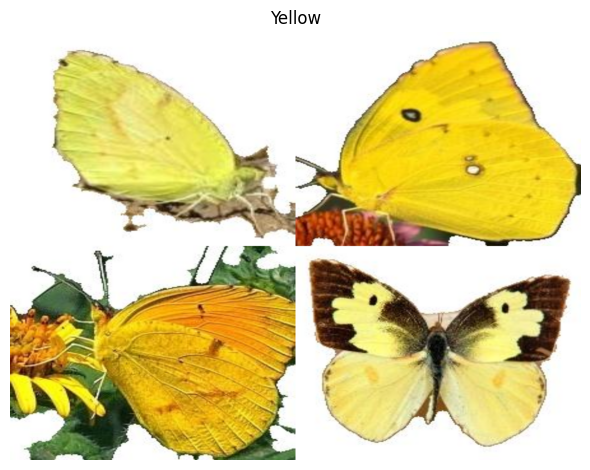

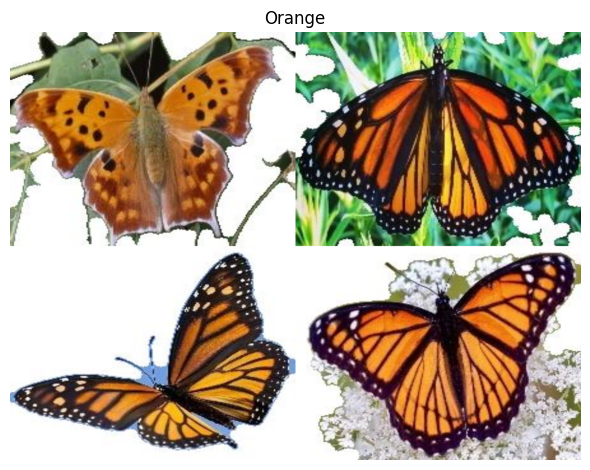

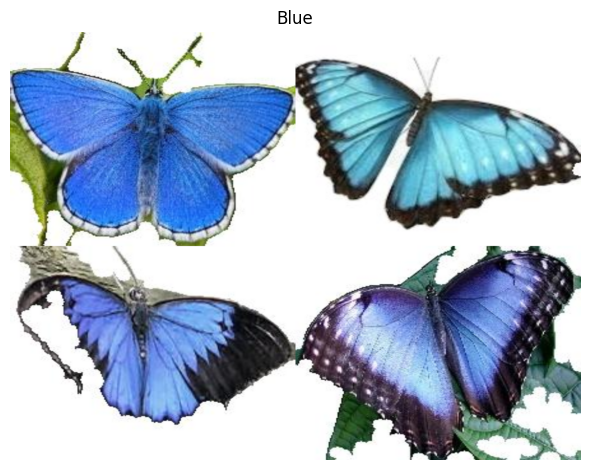

In [8]:
folder = "../data/background_removed"  
colour_groups = group_images_by_colour(folder)  # make collage for each butterfly type/colour

for colour_label, files in colour_groups.items():
    image_paths = [os.path.join(folder, f) for f in files]

    create_butterfly_collage(
        image_paths=image_paths,
        output_size=(1600, 1200),
        n=4,
        background_colour=(255, 255, 255),
        title=colour_label.capitalize()
    )

### Exercise 1.4

Can see that in each group, one butterfly looks different from the rest. It has a slightly different shape. Therefore, let's identify the most shape-outlier image (based on contours) from each group

In [ ]:
def get_largest_mask(image):
    """
    Extracts a binary mask of the largest object in the image, assuming a white background.

    Parameters:
        image (ndarray): Input RGB image as a NumPy array.

    Returns:
        ndarray: Boolean mask where `True` represents the largest detected object.
    """

    gray = color.rgb2gray(image) # convert to grayscale
    binary = gray < 0.85 # threshold to detect non-white pixels (assumes white background)
    cleaned = morphology.remove_small_objects(binary, min_size=50)

    labeled = measure.label(cleaned)
    regions = measure.regionprops(labeled)

    largest = max(regions, key=lambda r: r.area) # pick the largest object (assumed to be the butterfly)
    return labeled == largest.label

def get_hu_moments(mask):
    """
    Computes log-scaled Hu moments from a binary mask.

    Parameters:
        mask (ndarray): Boolean binary mask of the object.

    Returns:
        ndarray: A 1D array of 7 log-transformed Hu moments.
    """
    moments = measure.moments_central(mask) # compute central moments from the mask
    hu = measure.moments_hu(moments) # use those to find the 7 Hu moments which describe the shape 
    return np.log(np.abs(hu) + 1e-10) # for stability

def find_shape_outlier(image_paths):
    """
    Identifies the image with the most shape-dissimilar object based on Hu moments.

    Parameters:
        image_paths (list of str): List of paths to input images.

    Returns:
        tuple: (str or None, float or None)
            - The path to the image considered the most shape outlier.
            - The corresponding average distance in Hu moment space.
    """
    descriptors = []
    valid_paths = []

    for path in image_paths:

        image = io.imread(path) # read the image
        mask = get_largest_mask(image) # extract the largest shape mask from each image
        
        hu = get_hu_moments(mask)
        descriptors.append(hu)
        valid_paths.append(path)

    if len(descriptors) < 3:
        print("Not enough valid shapes found.")
        return None, None

    descriptors = np.array(descriptors)
    dist_matrix = squareform(pdist(descriptors, metric='euclidean')) # find pairwise distances between all Hu descriptors (using Euclidean distance)
    avg_dist = dist_matrix.mean(axis=1) # for each image, find the average distance to all others
    outlier_index = np.argmax(avg_dist) 

    return valid_paths[outlier_index], avg_dist[outlier_index] # return the image with the highest average distance (the most “different” shape)

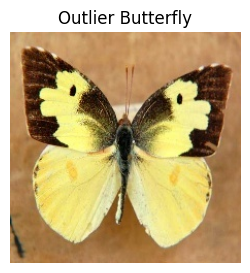


Outlier in YELLOW group: Image_559.jpg (score: 5.742)


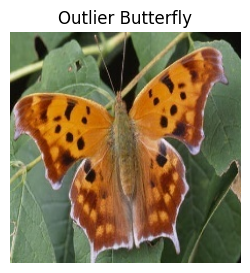


Outlier in ORANGE group: Image_643.jpg (score: 14.090)


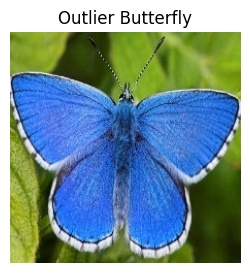


Outlier in BLUE group: Image_241.jpg (score: 9.121)


In [10]:
folder = "../data"

for butterfly_colour, files in colour_groups.items():
    image_paths = [os.path.join(folder, f) for f in files]

    outlier_path, score = find_shape_outlier(image_paths)
    outlier = io.imread(outlier_path)

    plt.figure(figsize=(3, 3))  
    plt.imshow(outlier)
    plt.axis('off')  
    plt.title("Outlier Butterfly")
    plt.show()
    if outlier_path:
        print(f"\nOutlier in {butterfly_colour.upper()} group: {os.path.basename(outlier_path)} (score: {score:.3f})")